## HI-VAEによる離散値および連続値を含むデータセットによるデータ生成
##### Transfusion Data から、condition, outcome を除いたFeatureをencode, decode

In [1]:
import tensorflow as tf
import graph_new
import parser_arguments
import time
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from matplotlib import pyplot as plt
#import plot_functions
import read_functions
import os
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)

In [2]:
def print_loss(epoch, start_time, avg_loss, avg_test_loglik, avg_KL_s, avg_KL_z):
    print("Epoch: [%2d]  time: %4.4f, train_loglik: %.8f, KL_z: %.8f, KL_s: %.8f, ELBO: %.8f, Test_loglik: %.8f"
          % (epoch, time.time() - start_time, avg_loss, avg_KL_z, avg_KL_s, avg_loss-avg_KL_z-avg_KL_s, avg_test_loglik))


plt.close('all')

In [3]:
df_trans = pd.read_csv('/home/ubuntu/ai-study/DeepLearning基礎講座/Spring Seminar & Project/Team15/sample_dataset/transfusion_data_0321.csv')

In [4]:
df_trans.head()

,Unnamed: 0,TXA.day1_2,dth24h,Outcome.Survive,complication.thrombosis,sex,age,jcs,Year,Fibrinogen.day1_2,X7thCoag.day1_2,FFP.dose.day1_2,Plt.dose.day1_2,Trauma_Severity_Score,Head_injury,RCC.dose.day1,RCC.dose.day1_2
0,0,False,0,True,False,1,33,100,2010,False,False,10.000,0,10.84,True,10,10
1,1,False,0,True,False,2,73,10,2010,False,False,3.333,0,3.26,True,10,10
2,2,True,0,True,False,2,55,1,2010,False,False,18.000,20,9.92,False,26,26
3,3,False,0,True,False,2,52,0,2010,False,False,13.332,0,3.12,False,12,12
4,4,False,0,True,False,1,18,0,2010,False,False,6.000,0,2.26,False,0,14


In [5]:
df_trans.shape

(7645, 17)

In [6]:
df_trans.columns

Index(['Unnamed: 0', 'TXA.day1_2', 'dth24h', 'Outcome.Survive',
       'complication.thrombosis', 'sex', 'age', 'jcs', 'Year',
       'Fibrinogen.day1_2', 'X7thCoag.day1_2', 'FFP.dose.day1_2',
       'Plt.dose.day1_2', 'Trauma_Severity_Score', 'Head_injury',
       'RCC.dose.day1', 'RCC.dose.day1_2'],
      dtype='object')

TXA.day1_2: 治療の有無（タグ）<- 入力には含めない。  
  
dth24h, Outcome.Survive, complication.Survive:  
outcome(潜在空間からDNNしたoutcomeに相当）  

その他は入力Xに相当。  
sex:カテゴリ変数(binary)   
age:連続変数（整数）   
jcs:カテゴリ変数（値は0,1,2,3,10,20,30,100,200,300)の10種類で数が大きいほど重症   
Year:カテゴリ変数（傾向スコアでは年度毎の偏りをなくすために使っていましたが無視しても大丈夫かもしれません。そのまま変数に入れても差し支えないかもしれません）   
Fibrinogen.day1_2, X7thCoag.day1_2：カテゴリ変数((binary)   
FFP.dose.day1_2,Plt.dose.day1_2:連続変数（正値のみとる）   
Trauma_Severity_Score(連続変数）おそらく一番outcomeに作用する   
Head_injury:カテゴリ変数((binary)   
RCC.dose.day1：これは変数に入れないで下さい。   
RCC.dose.day1_2:連続変数（10以上の整数)    

In [7]:
train_columns = ['sex', 'age', 'jcs', 'Year', 'Fibrinogen.day1_2', 'X7thCoag.day1_2', 'FFP.dose.day1_2',
                 'Plt.dose.day1_2', 'Trauma_Severity_Score', 'Head_injury', 'RCC.dose.day1_2']

In [8]:
len(train_columns)

11

In [9]:
df_train_data = df_trans[train_columns]

In [10]:
df_train_data.head()

,sex,age,jcs,Year,Fibrinogen.day1_2,X7thCoag.day1_2,FFP.dose.day1_2,Plt.dose.day1_2,Trauma_Severity_Score,Head_injury,RCC.dose.day1_2
0,1,33,100,2010,False,False,10.000,0,10.84,True,10
1,2,73,10,2010,False,False,3.333,0,3.26,True,10
2,2,55,1,2010,False,False,18.000,20,9.92,False,26
3,2,52,0,2010,False,False,13.332,0,3.12,False,12
4,1,18,0,2010,False,False,6.000,0,2.26,False,14


In [11]:
df_train_data = df_train_data.replace({True:1, False:0})

In [12]:
df_train_data['Trauma_Severity_Score'].min()

-2.5

In [13]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 11 columns):
sex                      7645 non-null int64
age                      7645 non-null int64
jcs                      7645 non-null int64
Year                     7645 non-null int64
Fibrinogen.day1_2        7645 non-null int64
X7thCoag.day1_2          7645 non-null int64
FFP.dose.day1_2          7645 non-null float64
Plt.dose.day1_2          7645 non-null int64
Trauma_Severity_Score    7645 non-null float64
Head_injury              7645 non-null int64
RCC.dose.day1_2          7645 non-null int64
dtypes: float64(2), int64(9)
memory usage: 657.1 KB


In [14]:
df_train_data.to_csv('transfusion/transfusion.csv', header=False, index=False)

###  data types
'sex', cat, 2   
'age', pos,    
'jcs', ordinal, 10   
'Year', cat, 6   
'Fibrinogen.day1_2', cat, 2   
'X7thCoag.day1_2', cat, 2    
'FFP.dose.day1_2', pos,    
'Plt.dose.day1_2', pos,    
'Trauma_Severity_Score', real   
'Head_injury', cat, 2   
'RCC.dose.day1_2', pos,    

In [15]:
df_data_types = pd.DataFrame({'type':  ['cat', 'pos', 'ordinal', 'cat',  'cat', 'cat', 'pos', 'pos', 'real', 'cat', 'pos'],
                              'dim':   [ 2,     1,     10,        6,      2,     2,     1,     1,     1,     2,     1],
                              'nclass':[ 2,     None,  10,        6,      2,     2,     None,  None,  None, 2,     None]})
df_data_types.to_csv('transfusion/trans_data_types.csv', index=False)

In [16]:
# settings = '--epochs 100 --model_name model_HIVAE_inputDropout --restore 0 --train 1 \
#             --data_file transfusion/transfusion.csv --types_file transfusion/trans_data_types.csv --miss_file transfusion/Missing_1.csv \
#             --batch_size 1000 --save 1001 --save_file transfusion_model_test\
#             --dim_latent_s 5 --dim_latent_z 5 --dim_latent_y 3 \
#             --miss_percentage_train 0.0 --miss_percentage_test 0.0'

In [17]:
settings = '--epochs 100 --model_name model_HIVAE_inputDropout --restore 0 --train 1 \
            --data_file transfusion/transfusion.csv --types_file transfusion/trans_data_types.csv \
            --batch_size 100 --save 1001 --save_file transfusion_model_test\
            --dim_latent_s 10 --dim_latent_z 10 --dim_latent_y 5 \
            --miss_percentage_train 0.0 --miss_percentage_test 0.0'

In [18]:
argvals = settings.split()
args = parser_arguments.getArgs(argvals)
argvals

['--epochs',
 '100',
 '--model_name',
 'model_HIVAE_inputDropout',
 '--restore',
 '0',
 '--train',
 '1',
 '--data_file',
 'transfusion/transfusion.csv',
 '--types_file',
 'transfusion/trans_data_types.csv',
 '--batch_size',
 '100',
 '--save',
 '1001',
 '--save_file',
 'transfusion_model_test',
 '--dim_latent_s',
 '10',
 '--dim_latent_z',
 '10',
 '--dim_latent_y',
 '5',
 '--miss_percentage_train',
 '0.0',
 '--miss_percentage_test',
 '0.0']

In [19]:
#Create a directoy for the save file
if not os.path.exists('./Saved_Networks/' + args.save_file):
    os.makedirs('./Saved_Networks/' + args.save_file)

network_file_name='./Saved_Networks/' + args.save_file + '/' + args.save_file +'.ckpt'
log_file_name='./Saved_Network/' + args.save_file + '/log_file_' + args.save_file +'.txt'

print(args)

Namespace(batch_size=100, data_file='transfusion/transfusion.csv', dim_latent_s=10, dim_latent_y=5, dim_latent_y_partition=None, dim_latent_z=10, display=1, epochs=100, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=1001, save_file='transfusion_model_test', train=1, true_miss_file=None, types_file='transfusion/trans_data_types.csv')


In [20]:
#Creating graph
sess_HVAE = tf.Graph()

In [21]:
with sess_HVAE.as_default():
    
    tf_nodes = graph_new.HVAE_graph(args.model_name, args.types_file, args.batch_size,
                                    learning_rate=1e-3, z_dim=args.dim_latent_z, y_dim=args.dim_latent_y, 
                                    s_dim=args.dim_latent_s, y_dim_partition=args.dim_latent_y_partition)

[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[*] Defining Cost function...


In [22]:
################### Running the VAE Training #################################

train_data, types_dict, miss_mask, true_miss_mask, n_samples = read_functions.read_data(args.data_file, args.types_file, args.miss_file, 
                                                                                        args.true_miss_file)
#Get an integer number of batches
n_batches = int(np.floor(np.shape(train_data)[0]/args.batch_size))
#Compute the real miss_mask
miss_mask = np.multiply(miss_mask, true_miss_mask)

In [23]:
train_data.shape

(7645, 29)

In [24]:
with tf.Session(graph=sess_HVAE) as session:
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
        
    if(args.restore == 1):
        saver.restore(session, network_file_name)
        print("Model restored.")
    else:
#        saver = tf.train.Saver()
        print('Initizalizing Variables ...')
        tf.global_variables_initializer().run()
    
    print('Training the HVAE ...')
    if(args.train == 1):
        
        start_time = time.time()
        # Training cycle
        
        loglik_epoch = []
        testloglik_epoch = []
        KL_s_epoch = []
        KL_z_epoch = []
        for epoch in range(args.epochs):
            avg_loss = 0.
            avg_KL_s = 0.
            avg_KL_z = 0.
            samples_list = []
            p_params_list = []
            q_params_list = []
            log_p_x_total = []
            log_p_x_missing_total = []
            
            # Annealing of Gumbel-Softmax parameter
            tau = np.max([1.0 - 0.001*epoch,1e-3])
            
#             #Randomize the data in the mini-batches
#             random_perm = np.random.permutation(range(np.shape(train_data)[0]))
#             train_data_aux = train_data[random_perm,:]
#             miss_mask_aux = miss_mask[random_perm,:]
#             true_miss_mask_aux = true_miss_mask[random_perm,:]

            train_data_aux = train_data[:]
            miss_mask_aux = miss_mask[:]
            true_miss_mask_aux = true_miss_mask[:]

            for i in range(n_batches):      
                
                #Create inputs for the feed_dict
                data_list, miss_list = read_functions.next_batch(train_data_aux, types_dict, miss_mask_aux, args.batch_size, index_batch=i)

                #Delete not known data (input zeros)
                data_list_observed = [data_list[i]*np.reshape(miss_list[:,i],[args.batch_size,1]) for i in range(len(data_list))]
                
                #Create feed dictionary
                feedDict = {i: d for i, d in zip(tf_nodes['ground_batch'], data_list)}
                feedDict.update({i: d for i, d in zip(tf_nodes['ground_batch_observed'], data_list_observed)})
                feedDict[tf_nodes['miss_list']] = miss_list
                feedDict[tf_nodes['tau_GS']] = tau
                
                #Running VAE
                _,loss,KL_z,KL_s,samples,log_p_x,log_p_x_missing,p_params,q_params  = session.run([tf_nodes['optim'], 
                                                                                                   tf_nodes['loss_re'], 
                                                                                                   tf_nodes['KL_z'], 
                                                                                                   tf_nodes['KL_s'], 
                                                                                                   tf_nodes['samples'],
                                                                                                   tf_nodes['log_p_x'], 
                                                                                                   tf_nodes['log_p_x_missing'],
                                                                                                   tf_nodes['p_params'],
                                                                                                   tf_nodes['q_params']],
                                                                                                  feed_dict=feedDict)
                
                #Collect all samples, distirbution parameters and logliks in lists
                samples_list.append(samples)
                p_params_list.append(p_params)
                q_params_list.append(q_params)
                log_p_x_total.append(log_p_x)
                log_p_x_missing_total.append(log_p_x_missing)
                
                # Compute average loss
                avg_loss += np.mean(loss)
                avg_KL_s += np.mean(KL_s)
                avg_KL_z += np.mean(KL_z)
                
            #Concatenate samples in arrays
            s_total, z_total, y_total, est_data = read_functions.samples_concatenation(samples_list)
            
            #Transform discrete variables back to the original values
            train_data_transformed = read_functions.discrete_variables_transformation(train_data_aux[:n_batches*args.batch_size,:], 
                                                                                      types_dict)
            est_data_transformed = read_functions.discrete_variables_transformation(est_data, types_dict)
            est_data_imputed = read_functions.mean_imputation(train_data_transformed, miss_mask_aux[:n_batches*args.batch_size,:], 
                                                              types_dict)
            
            #Create global dictionary of the distribution parameters
            p_params_complete = read_functions.p_distribution_params_concatenation(p_params_list, types_dict, args.dim_latent_z, 
                                                                                   args.dim_latent_s)
            q_params_complete = read_functions.q_distribution_params_concatenation(q_params_list,  args.dim_latent_z, args.dim_latent_s)
            
            #Compute mean and mode of our loglik models
            loglik_mean, loglik_mode = read_functions.statistics(p_params_complete['x'],types_dict)
                
            #Try this for the errors
            error_train_mean, error_test_mean = read_functions.error_computation(train_data_transformed, loglik_mean, 
                                                                                 types_dict, miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_mode, error_test_mode = read_functions.error_computation(train_data_transformed, loglik_mode, 
                                                                                 types_dict, miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_samples, error_test_samples = read_functions.error_computation(train_data_transformed, est_data_transformed, 
                                                                                       types_dict, 
                                                                                       miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_imputed, error_test_imputed = read_functions.error_computation(train_data_transformed, est_data_imputed, 
                                                                                       types_dict, 
                                                                                       miss_mask_aux[:n_batches*args.batch_size,:])
                
            #Compute test-loglik from log_p_x_missing
            log_p_x_total = np.transpose(np.concatenate(log_p_x_total,1))
            log_p_x_missing_total = np.transpose(np.concatenate(log_p_x_missing_total,1))
            if args.true_miss_file:
                log_p_x_missing_total = np.multiply(log_p_x_missing_total,true_miss_mask_aux[:n_batches*args.batch_size,:])
            avg_test_loglik = np.sum(log_p_x_missing_total)/np.sum(1.0-miss_mask_aux)

            # Display logs per epoch step
            if epoch % args.display == 0:
                print_loss(epoch, start_time, avg_loss/n_batches, avg_test_loglik, avg_KL_s/n_batches, avg_KL_z/n_batches)
                print("")
                
            #Compute train and test loglik per variables
            loglik_per_variable = np.sum(log_p_x_total,0)/np.sum(miss_mask_aux,0)
            loglik_per_variable_missing = np.sum(log_p_x_missing_total,0)/np.sum(1.0-miss_mask_aux,0)
            
            #Store evolution of all the terms in the ELBO
            loglik_epoch.append(loglik_per_variable)
            testloglik_epoch.append(loglik_per_variable_missing)
            KL_s_epoch.append(avg_KL_s/n_batches)
            KL_z_epoch.append(avg_KL_z/n_batches)
            
            
            if epoch % args.save == 0:
                print('Saving Variables ...')  
                save_path = saver.save(session, network_file_name)    
            
        print('Training Finished ...')
        
        
    #Test phase
    else:
        
        start_time = time.time()
        # Testing cycle
        
        f_toy2, ax_toy2 = plt.subplots(4,4,figsize=(8, 8))
        loglik_epoch = []
        testloglik_epoch = []
        for epoch in range(args.epochs):
            avg_loss = 0.
            avg_KL_s = 0.
            avg_KL_y = 0.
            avg_KL_z = 0.
            samples_list = []
            p_params_list = []
            q_params_list = []
            log_p_x_total = []
            log_p_x_missing_total = []
            
            # Constant Gumbel-Softmax parameter (where we have finished the annealing)
            tau = 1e-3
            
            for i in range(n_batches):      
                
                #Create train minibatch
                data_list, miss_list = read_functions.next_batch(train_data, types_dict, miss_mask, args.batch_size, 
                                                                 index_batch=i) # miss_percentage=args.miss_percentage_train)

                #Delete not known data
                data_list_observed = [data_list[i]*np.reshape(miss_list[:,i],[args.batch_size,1]) for i in range(len(data_list))]
                
                #Create feed dictionary
                feedDict = {i: d for i, d in zip(tf_nodes['ground_batch'], data_list)}
                feedDict.update({i: d for i, d in zip(tf_nodes['ground_batch_observed'], data_list_observed)})
                feedDict[tf_nodes['miss_list']] = miss_list
                feedDict[tf_nodes['tau_GS']] = tau
                
                #Get samples from the model
#                 KL_s,loss,samples,dec_data,log_p_x,log_p_x_missing,loss_total,KL_z,p_params,q_params = session.run([tf_nodes['KL_s'], 
                KL_s,loss,samples,log_p_x,log_p_x_missing,loss_total,KL_z,p_params,q_params = session.run([tf_nodes['KL_s'], 
                                                                                                           tf_nodes['loss_re'],
                                                                                                           tf_nodes['samples'],
#                                                                                                          tf_nodes['dec_data'],
                                                                                                           tf_nodes['log_p_x'],
                                                                                                           tf_nodes['log_p_x_missing'],
                                                                                                           tf_nodes['loss'],
                                                                                                           tf_nodes['KL_z'],
                                                                                                           tf_nodes['p_params'],
                                                                                                           tf_nodes['q_params']],
                                                                                                          feed_dict=feedDict)
                
                #Get samples from the generator function (computing the mode of all distributions)
                samples_test,log_p_x_test,log_p_x_missing_test,test_params  = session.run([tf_nodes['samples_test'],
                                                                                           tf_nodes['log_p_x_test'],
                                                                                           tf_nodes['log_p_x_missing_test'],
                                                                                           tf_nodes['test_params']],
                                                                                          feed_dict=feedDict)
                
                
                samples_list.append(samples)
                p_params_list.append(test_params)
                q_params_list.append(q_params)
                log_p_x_total.append(log_p_x)
                log_p_x_missing_total.append(log_p_x_missing)
                
                # Compute average loss
                avg_loss += np.mean(loss)
                avg_KL_s += np.mean(KL_s)
                avg_KL_z += np.mean(KL_z)
                
            #Separate the samples from the batch list
#             s_aux, z_aux, y_total, est_data = read_functions.samples_concatenation(samples_list, args.dim_latent_z, args.dim_latent_s)
            s_aux, z_aux, y_total, est_data = read_functions.samples_concatenation(samples_list)

            
            #Transform discrete variables to original values
            train_data_transformed = read_functions.discrete_variables_transformation(train_data, types_dict)
            est_data_transformed = read_functions.discrete_variables_transformation(est_data, types_dict)
            est_data_imputed = read_functions.mean_imputation(train_data_transformed, miss_mask, types_dict)
            
            #Create global dictionary of the distribution parameters
            p_params_complete = read_functions.p_distribution_params_concatenation(p_params_list, types_dict, args.dim_latent_z, 
                                                                                   args.dim_latent_s)
            q_params_complete = read_functions.q_distribution_params_concatenation(q_params_list, args.dim_latent_z, args.dim_latent_s)
            
            #Compute mean and mode of our loglik models
            loglik_mean, loglik_mode = read_functions.statistics(p_params_complete['x'],types_dict)
                
            #Try this for the errors
            error_train_mean, error_test_mean = read_functions.error_computation(train_data_transformed, loglik_mean, types_dict, miss_mask)
            error_train_mode, error_test_mode = read_functions.error_computation(train_data_transformed, loglik_mode, types_dict, miss_mask)
            error_train_samples, error_test_samples = read_functions.error_computation(train_data_transformed, est_data_transformed, 
                                                                                       types_dict, miss_mask)
            error_train_imputed, error_test_imputed = read_functions.error_computation(train_data_transformed, est_data_imputed,
                                                                                       types_dict, miss_mask)
#            error_train_mean, error_test_mean_den = read_functions.error_computation_mean_den(train_data_transformed, loglik_mean, types_dict, miss_mask)
                
#            Compute test-loglik from log_p_x_missing
            log_p_x_missing_total = np.transpose(np.concatenate(log_p_x_missing_total,1))
            if args.true_miss_file:
                log_p_x_missing_total = np.multiply(log_p_x_missing_total,true_miss_mask)
            avg_test_loglik = np.sum(log_p_x_missing_total)/np.sum(1.0-miss_mask)

            # Display logs per epoch step
            if epoch % args.display == 0:
                print_loss(epoch, start_time, avg_loss/n_batches, avg_test_loglik, avg_KL_s/n_batches, avg_KL_z/n_batches)
                print("")
                
            #Plot evolution of test loglik
            loglik_per_variable = np.sum(np.concatenate(log_p_x_total,1),1)/np.sum(miss_mask,0)
            loglik_per_variable_missing = np.sum(log_p_x_missing_total,0)/np.sum(1.0-miss_mask,0)
            loglik_epoch.append(loglik_per_variable)
            testloglik_epoch.append(loglik_per_variable_missing)
 


Initizalizing Variables ...
Training the HVAE ...
Epoch: [ 0]  time: 4.1210, train_loglik: -24.88351325, KL_z: 0.09832583, KL_s: 0.03371492, ELBO: -25.01555399, Test_loglik: nan

Saving Variables ...
Epoch: [ 1]  time: 5.3627, train_loglik: -23.89292438, KL_z: 0.13462163, KL_s: 0.27462229, ELBO: -24.30216831, Test_loglik: nan

Epoch: [ 2]  time: 6.1882, train_loglik: -22.63385984, KL_z: 0.20658755, KL_s: 1.04944712, ELBO: -23.88989451, Test_loglik: nan

Epoch: [ 3]  time: 6.9526, train_loglik: -22.16690367, KL_z: 0.24526130, KL_s: 1.44681648, ELBO: -23.85898145, Test_loglik: nan

Epoch: [ 4]  time: 7.8455, train_loglik: -21.66080934, KL_z: 0.39060994, KL_s: 1.50921335, ELBO: -23.56063262, Test_loglik: nan

Epoch: [ 5]  time: 8.7618, train_loglik: -21.38939868, KL_z: 0.42099654, KL_s: 1.69930085, ELBO: -23.50969607, Test_loglik: nan

Epoch: [ 6]  time: 9.6141, train_loglik: -21.12322499, KL_z: 0.49370517, KL_s: 1.88347344, ELBO: -23.50040359, Test_loglik: nan

Epoch: [ 7]  time: 10.5268

Epoch: [63]  time: 58.7873, train_loglik: -18.62854129, KL_z: 1.07850319, KL_s: 1.80087405, ELBO: -21.50791854, Test_loglik: nan

Epoch: [64]  time: 59.6390, train_loglik: -18.61414199, KL_z: 1.07621222, KL_s: 1.80173235, ELBO: -21.49208655, Test_loglik: nan

Epoch: [65]  time: 60.4344, train_loglik: -18.60465163, KL_z: 1.08964192, KL_s: 1.80227541, ELBO: -21.49656895, Test_loglik: nan

Epoch: [66]  time: 61.2376, train_loglik: -18.60536688, KL_z: 1.09318749, KL_s: 1.80366139, ELBO: -21.50221577, Test_loglik: nan

Epoch: [67]  time: 62.0554, train_loglik: -18.56352811, KL_z: 1.09779884, KL_s: 1.80531831, ELBO: -21.46664525, Test_loglik: nan

Epoch: [68]  time: 62.9700, train_loglik: -18.56377127, KL_z: 1.09254061, KL_s: 1.80401271, ELBO: -21.46032460, Test_loglik: nan

Epoch: [69]  time: 63.7366, train_loglik: -18.53408477, KL_z: 1.09400016, KL_s: 1.80409617, ELBO: -21.43218110, Test_loglik: nan

Epoch: [70]  time: 64.5387, train_loglik: -18.54427004, KL_z: 1.09557000, KL_s: 1.80465346

In [25]:
train_arr = np.array(df_train_data)
train_arr.shape

(7645, 11)

In [26]:
est_data_transformed.shape

(7600, 11)

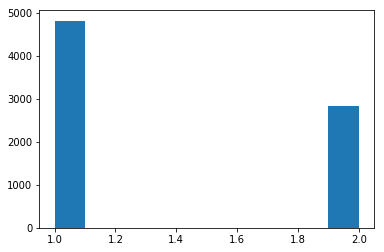

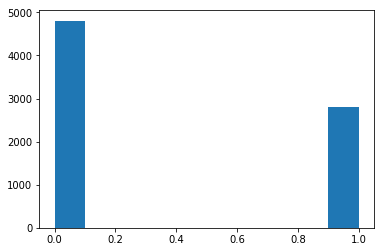

In [27]:
# 'sex', cat, 2
plt.hist(train_arr[:,0], bins=10)
plt.show()
plt.hist(est_data_transformed[:,0], bins=10)
plt.show()

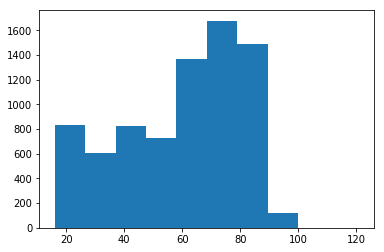

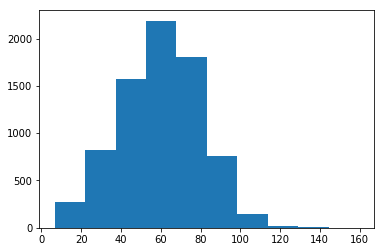

In [28]:
# 'age', pos,
plt.hist(train_arr[:,1], bins=10)
plt.show()
plt.hist(est_data_transformed[:,1], bins=10)
plt.show()

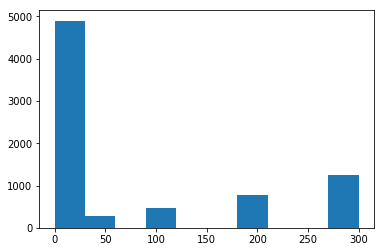

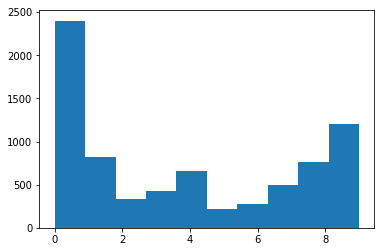

In [29]:
#''jcs', ordinal, 10
plt.hist(train_arr[:,2], bins=10)
plt.show()
plt.hist(est_data_transformed[:,2], bins=10)
plt.show()

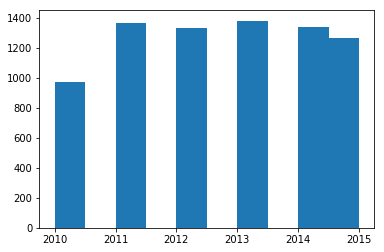

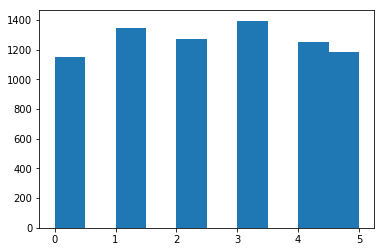

In [30]:
# 'Year', cat, 6
plt.hist(train_arr[:,3], bins=10)
plt.show()
plt.hist(est_data_transformed[:,3], bins=10)
plt.show()

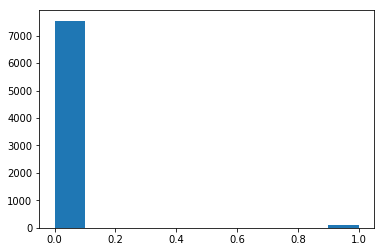

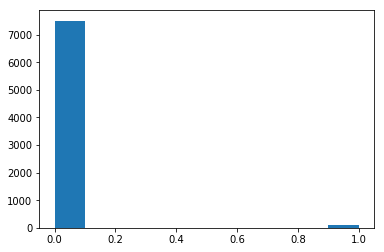

In [31]:
# 'Fibrinogen.day1_2', cat, 2
plt.hist(train_arr[:,4], bins=10)
plt.show()
plt.hist(est_data_transformed[:,4], bins=10)
plt.show()

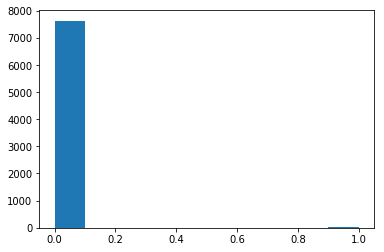

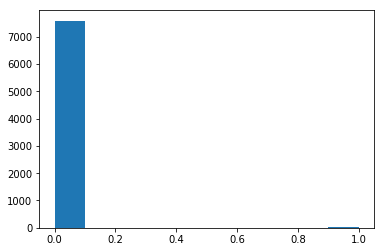

In [32]:
# 'X7thCoag.day1_2', cat, 2
plt.hist(train_arr[:,5], bins=10)
plt.show()
plt.hist(est_data_transformed[:,5], bins=10)
plt.show()

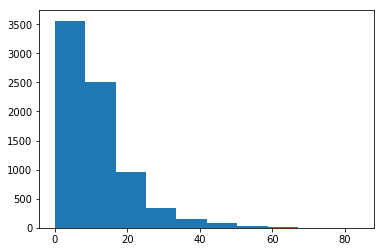

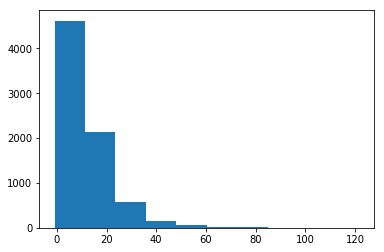

In [33]:
# 'FFP.dose.day1_2', pos,
plt.hist(train_arr[:,6], bins=10)
plt.show()
plt.hist(est_data_transformed[:,6], bins=10)
plt.show()

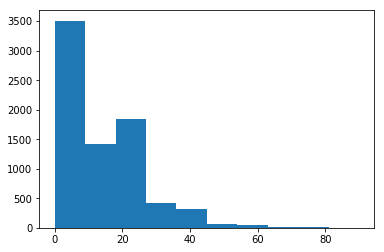

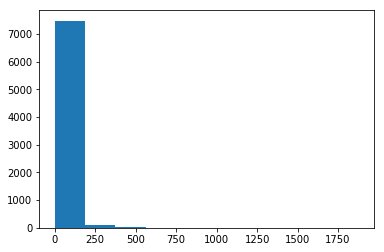

In [34]:
# 'Plt.dose.day1_2', pos,
plt.hist(train_arr[:,7], bins=10)
plt.show()
plt.hist(est_data_transformed[:,7], bins=10)
plt.show()

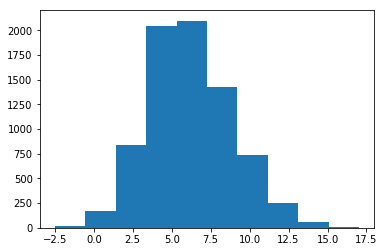

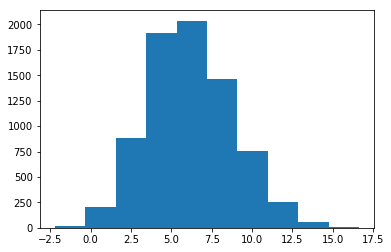

In [35]:
# 'Trauma_Severity_Score', pos
plt.hist(train_arr[:,8], bins=10)
plt.show()
plt.hist(est_data_transformed[:,8], bins=10)
plt.show()

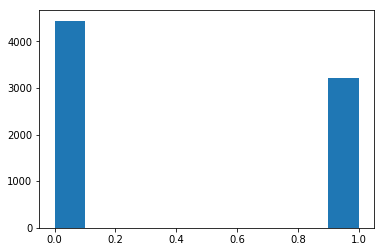

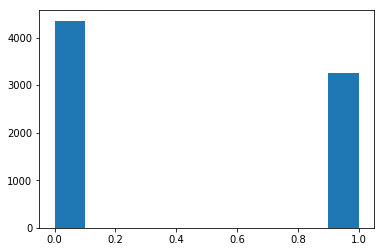

In [36]:
# 'Head_injury', cat, 2
plt.hist(train_arr[:,9], bins=10)
plt.show()
plt.hist(est_data_transformed[:,9], bins=10)
plt.show()

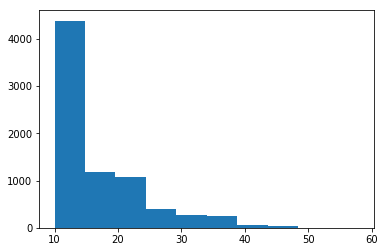

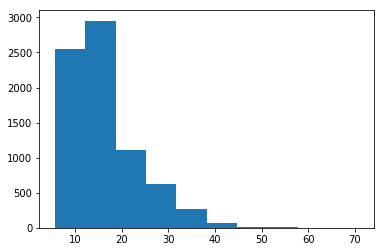

In [37]:
# 'RCC.dose.day1_2', pos,
plt.hist(train_arr[:,10], bins=10)
plt.show()
plt.hist(est_data_transformed[:,10], bins=10)
plt.show()

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time

import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [39]:
df_treat_outcome = pd.read_csv('/home/ubuntu/ai-study/DeepLearning基礎講座/Spring Seminar & Project/Team15/sample_dataset/transfusion_data_0321.csv', 
                               usecols=['TXA.day1_2', 'dth24h', 'Outcome.Survive', 'complication.thrombosis'])

In [40]:
df_treat_outcome.head()

,TXA.day1_2,dth24h,Outcome.Survive,complication.thrombosis
0,False,0,True,False
1,False,0,True,False
2,True,0,True,False
3,False,0,True,False
4,False,0,True,False


In [41]:
df_treat_outcome['TXA.day1_2'].unique()

array([False,  True])

In [42]:
df_treat_outcome = df_treat_outcome.replace({True:1, False:0})

In [43]:
df_treat_outcome.head()

,TXA.day1_2,dth24h,Outcome.Survive,complication.thrombosis
0,0,0,1,0
1,0,0,1,0
2,1,0,1,0
3,0,0,1,0
4,0,0,1,0


In [44]:
rows = z_total.shape[0]
treat = np.array(df_treat_outcome)[:rows,0]
outcome = np.array(df_treat_outcome)[:rows,1:]

In [45]:
treat.shape

(7600,)

In [46]:
outcome.shape

(7600, 3)

In [47]:
#input_dim = len(data[0])-2
hidden_dim = 100
#output_dim = input_dim
cond_dim = 2
estimate_dim =3

In [48]:
batch_size = 100
# train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [49]:
def input_shaper(x,input_dim):
    return x.view(-1, input_dim).float()
    
def tag_shaper(tag):
    return torch.eye(2)[tag.long()].float()

In [50]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return h

In [51]:
split_point = 7000
treat_train = treat[:split_point]
treat_test = treat[split_point:]
outcome_train = outcome[:split_point]
outcome_test = outcome[split_point:]
z_total_train = z_total[:split_point]
z_total_test = z_total[split_point:]
s_total_train = s_total[:split_point]
s_total_test = s_total[split_point:]

In [52]:
sz_total_train = np.concatenate([z_total_train, s_total_train], 1)
sz_total_test = np.concatenate([z_total_test, s_total_test], 1)
print(sz_total_train.shape)
print(sz_total_test.shape)

(7000, 20)
(600, 20)


In [53]:
latent_dim = args.dim_latent_s + args.dim_latent_z

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [54]:
for epoch in range(1, 200):
    start = 0
    for _ in range(split_point//batch_size):
        end = start + batch_size
        y = tag_shaper(torch.tensor(treat_train[start:end]))
#         y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(torch.tensor(outcome_train[start:end]), estimate_dim)
#         o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        

        latent = torch.tensor(sz_total_train[start:end]).to(device)
        start = end
        
        output = model2(latent,y)
        train_loss = criterion(output,o)        
        train_loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    start = 0
    for _ in range((rows-split_point)//batch_size):
        end = start + batch_size
        y = tag_shaper(torch.tensor(treat_test[start:end]))
#         y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(torch.tensor(outcome_test[start:end]), estimate_dim)        
#         o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        
        latent = torch.tensor(sz_total_test[start:end]).to(device)
        start = end        
        
        output = model2(latent,y)
        test_loss = criterion(output,o)
        
        total_loss += test_loss * batch_size
        total += batch_size
    test_loss = total_loss / total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch, train_loss.item(), test_loss.item()))

Epochs:1, train_Loss:0.30750977993011475, test_Loss:0.30
Epochs:2, train_Loss:0.3024912476539612, test_Loss:0.29
Epochs:3, train_Loss:0.2926894724369049, test_Loss:0.28
Epochs:4, train_Loss:0.26643839478492737, test_Loss:0.26
Epochs:5, train_Loss:0.21023918688297272, test_Loss:0.20
Epochs:6, train_Loss:0.16597189009189606, test_Loss:0.16
Epochs:7, train_Loss:0.13935191929340363, test_Loss:0.13
Epochs:8, train_Loss:0.12402529269456863, test_Loss:0.11
Epochs:9, train_Loss:0.11544954776763916, test_Loss:0.10
Epochs:10, train_Loss:0.11067379266023636, test_Loss:0.10
Epochs:11, train_Loss:0.10793916881084442, test_Loss:0.10
Epochs:12, train_Loss:0.10626637935638428, test_Loss:0.09
Epochs:13, train_Loss:0.10511939972639084, test_Loss:0.09
Epochs:14, train_Loss:0.10425184667110443, test_Loss:0.09
Epochs:15, train_Loss:0.10354115813970566, test_Loss:0.09
Epochs:16, train_Loss:0.10292506217956543, test_Loss:0.09
Epochs:17, train_Loss:0.10237976163625717, test_Loss:0.09
Epochs:18, train_Loss:0.1

Epochs:144, train_Loss:0.08957355469465256, test_Loss:0.08
Epochs:145, train_Loss:0.08955033123493195, test_Loss:0.08
Epochs:146, train_Loss:0.089527428150177, test_Loss:0.08
Epochs:147, train_Loss:0.08950476348400116, test_Loss:0.08
Epochs:148, train_Loss:0.08948233723640442, test_Loss:0.08
Epochs:149, train_Loss:0.0894598662853241, test_Loss:0.08
Epochs:150, train_Loss:0.0894375815987587, test_Loss:0.08
Epochs:151, train_Loss:0.08941522985696793, test_Loss:0.08
Epochs:152, train_Loss:0.0893932580947876, test_Loss:0.08
Epochs:153, train_Loss:0.08937150985002518, test_Loss:0.08
Epochs:154, train_Loss:0.08935071527957916, test_Loss:0.08
Epochs:155, train_Loss:0.08933020383119583, test_Loss:0.08
Epochs:156, train_Loss:0.08930988609790802, test_Loss:0.08
Epochs:157, train_Loss:0.08929009735584259, test_Loss:0.08
Epochs:158, train_Loss:0.08927054703235626, test_Loss:0.08
Epochs:159, train_Loss:0.08925110101699829, test_Loss:0.08
Epochs:160, train_Loss:0.08923187851905823, test_Loss:0.08
Ep

In [55]:
pt_size = 20000
z_sample = 0.3* torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
uy_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated=model2(z_sample,uy_sample)

# 治療群を生成
plot_number = 1
ty_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated=model2(z_sample,ty_sample)

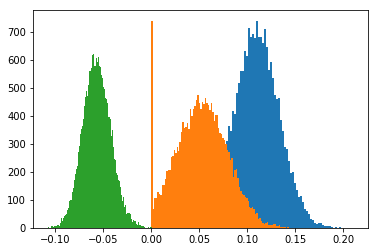

-0.0065930476

In [56]:
# dth24h
plt.hist(untreated[:,0].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,0].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,0].detach().cpu().numpy()-untreated[:,0].detach().cpu().numpy(),bins=100)
plt.show()
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

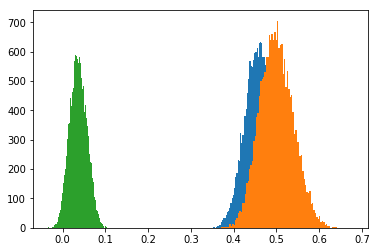

-0.0065930476

In [57]:
# Outcome.Survive
plt.hist(untreated[:,1].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,1].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,1].detach().cpu().numpy()-untreated[:,1].detach().cpu().numpy(),bins=100)
plt.show()
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

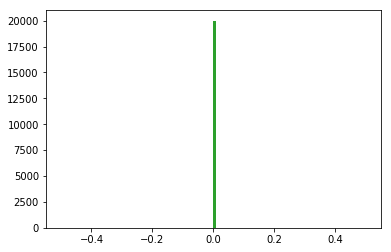

-0.0065930476

In [58]:
# complication.thrombosis
plt.hist(untreated[:,2].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,2].detach().cpu().numpy(),bins=100)
plt.hist(treated[:,2].detach().cpu().numpy()-untreated[:,2].detach().cpu().numpy(),bins=100)
plt.show()
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

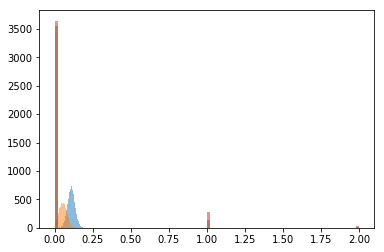

In [59]:
plt.hist(untreated[:,0].detach().cpu().numpy(), bins=100, alpha=0.5)
plt.hist(treated[:,0].detach().cpu().numpy(), bins=100, alpha=0.5)

plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==1)]['dth24h'], bins=100, alpha=0.5)
plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==0)]['dth24h'], bins=100, alpha=0.5)
plt.show()

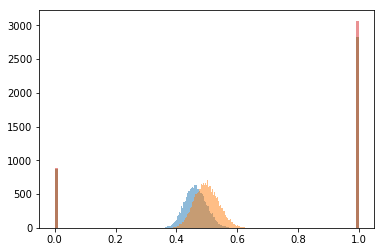

In [60]:
plt.hist(untreated[:,1].detach().cpu().numpy(), bins=100, alpha=0.5)
plt.hist(treated[:,1].detach().cpu().numpy(), bins=100, alpha=0.5)

plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==1)]['Outcome.Survive'], bins=100, alpha=0.5)
plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==0)]['Outcome.Survive'], bins=100, alpha=0.5)
plt.show()

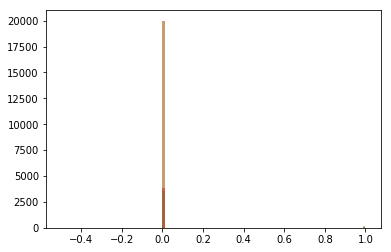

In [69]:
plt.hist(untreated[:,2].detach().cpu().numpy(), bins=100, alpha=0.5)
plt.hist(treated[:,2].detach().cpu().numpy(), bins=100, alpha=0.5)

plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==1)]['complication.thrombosis'], bins=100, alpha=0.5)
plt.hist(df_treat_outcome[(df_treat_outcome['TXA.day1_2']==0)]['complication.thrombosis'], bins=100, alpha=0.5)
plt.show()